In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm
import torch
from umap import UMAP
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR  
import deer.controllers as bc 
import yaml
from scipy.stats import pearsonr
from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy  

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from deer.environments.Figure8 import MyEnv as Env

In [3]:
import torch
torch.cuda.is_available = lambda : False

In [9]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
internal_dim = 16# 10
generic_exp_name = 'noisy_altT_eps0.5_test' #'noisy_altT_eps0.5_volweight' #'noisy_altT'
exp_name = f'{generic_exp_name}_dm_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'

# Run test experiments

noisy_altT_eps0.5_test_mb_2


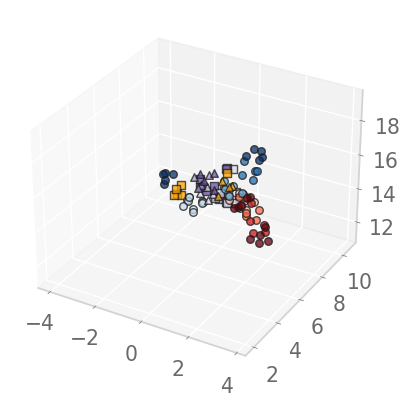

noisy_altT_eps0.5_test_mb_4


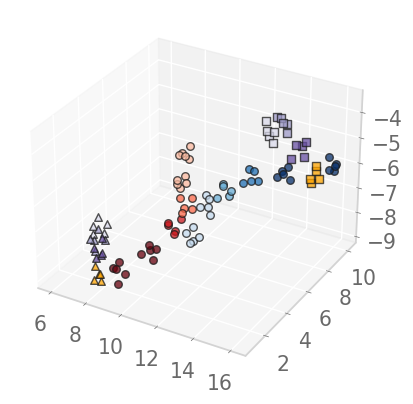

noisy_altT_eps0.5_test_mb_10


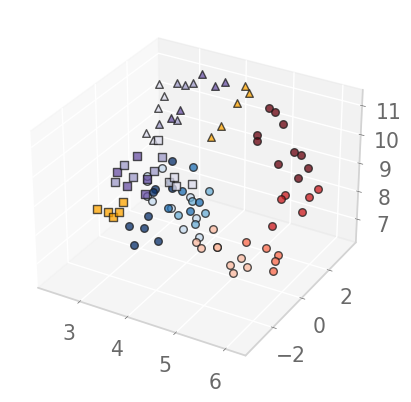

noisy_altT_eps0.5_test_mb_1


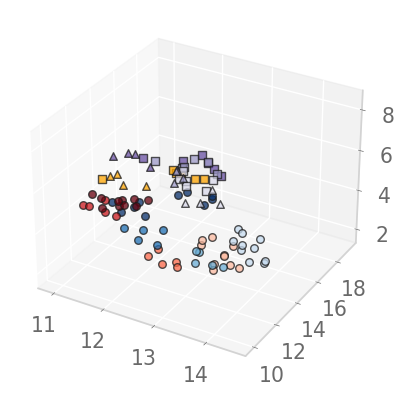

noisy_altT_eps0.5_test_mb_7


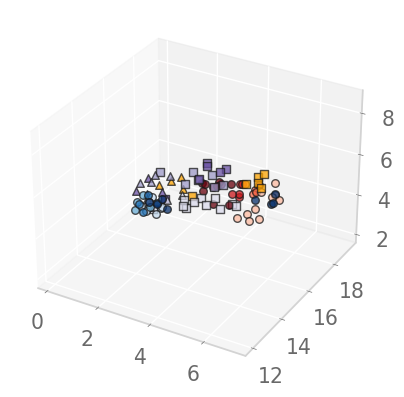

noisy_altT_eps0.5_test_mb_13


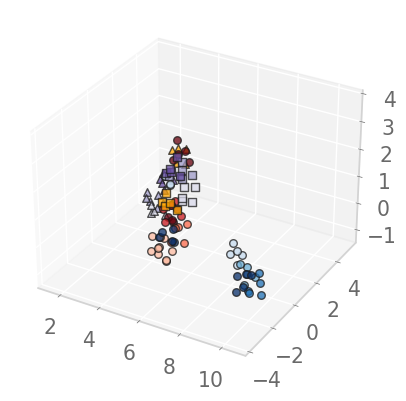

noisy_altT_eps0.5_test_mb_11


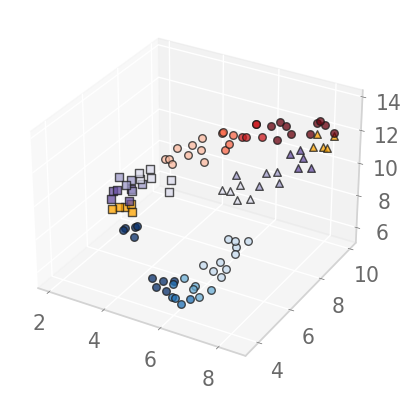

noisy_altT_eps0.5_test_mb_6


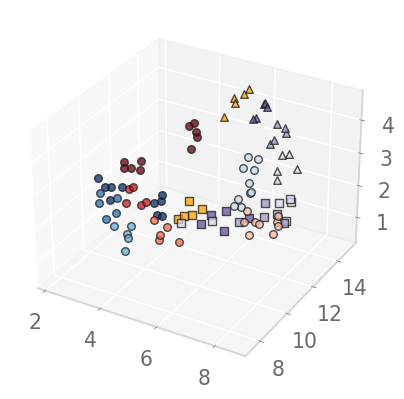

noisy_altT_eps0.5_test_mb_5


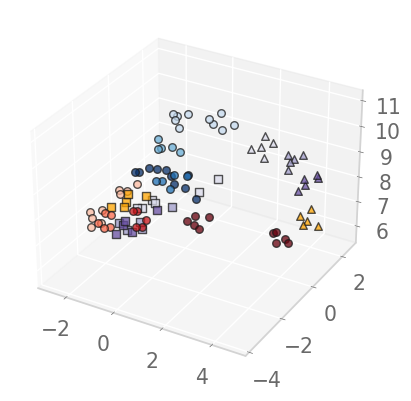

noisy_altT_eps0.5_test_mb_3


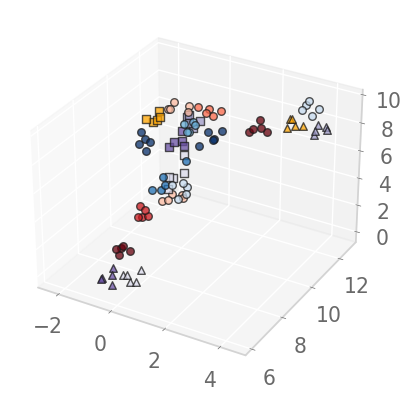

noisy_altT_eps0.5_test_mb_15


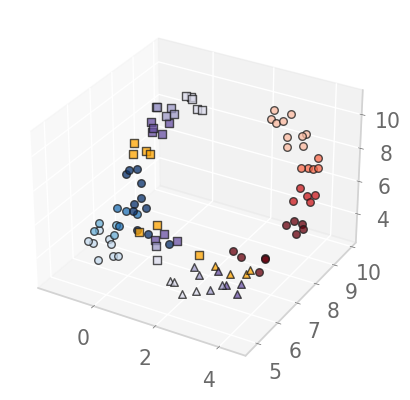

noisy_altT_eps0.5_test_mb_0


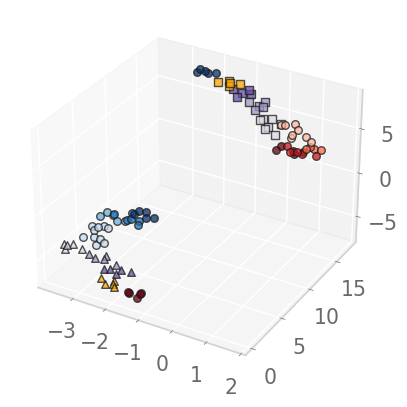

noisy_altT_eps0.5_test_mb_12


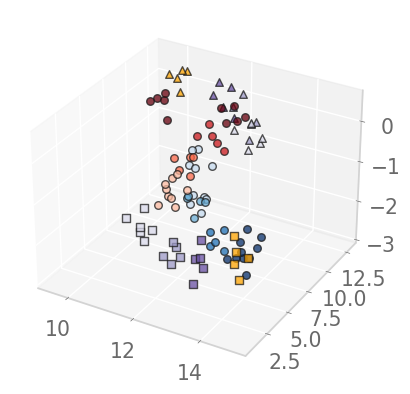

noisy_altT_eps0.5_test_mb_9


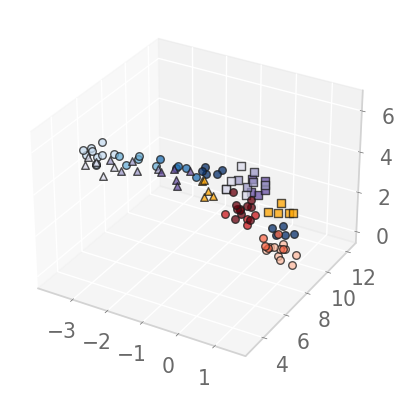

noisy_altT_eps0.5_test_mb_14


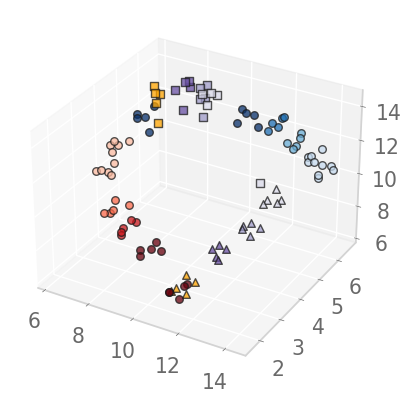

noisy_altT_eps0.5_test_mb_8


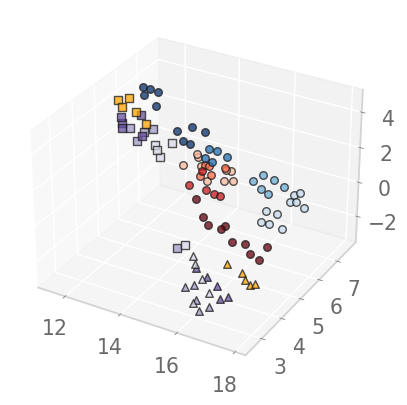

In [10]:
corr = []
stem_loc = []
score = []
model = []
for model_name in os.listdir(nnets_dir):
    print(model_name)
    if 'altT' not in model_name: continue
    if ('mf' not in model_name) and ('mb' not in model_name): continue
    fname = f'{generic_exp_name}_mb' if 'mb' in model_name else f'{generic_exp_name}_mf'
    #fname = f'noisy_altT_mb' if 'mb' in model_name else f'noisy_altT_mf'
    
    with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp_name}/{model_name}'
    parameters['internal_dim'] = internal_dim
    env = Env(                                                                     
        give_rewards=parameters['figure8_give_rewards'],                           
        higher_dim_obs=parameters['higher_dim_obs'],                               
        show_rewards=parameters['show_rewards'], plotfig=False,
        obs_noise=0.
        ) 
    rng = np.random.RandomState()
    learning_algo = CRAR(                                                          
        env, parameters['freeze_interval'], parameters['batch_size'], rng,         
        internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
        nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
        double_Q=True, loss_weights=parameters['loss_weights'],                    
        encoder_type=parameters['encoder_type'], mem_len=parameters['mem_len'],
        train_len=parameters['train_len']  
        )   
    train_policy = EpsilonGreedyPolicy(                                     
        learning_algo, env.nActions(), rng, epsilon=1.)             
    test_policy = EpsilonGreedyPolicy(                                      
        learning_algo, env.nActions(), rng, 0.)  
    agent = NeuralAgent(                                                        
        env, learning_algo, parameters['replay_memory_size'], 1,                
        parameters['batch_size'], rng, save_dir=engram_dir,                     
        train_policy=train_policy, test_policy=test_policy)
    agent.attach(bc.LearningRateController(                                     
        initial_learning_rate=parameters['learning_rate'],                      
        learning_rate_decay=parameters['learning_rate_decay'],                  
        periodicity=1))                                                         
    agent.attach(bc.TrainerController(                                          
        evaluate_on='action',  periodicity=parameters['update_frequency'],      
        show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
    best_controller = bc.FindBestController(                                    
        validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
    agent.attach(best_controller)                                               
    agent.attach(bc.InterleavedTestEpochController(                             
        id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
        periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))
    try:
        agent.setNetwork(parameters['fname'] + '/fname', nEpoch=40)
    except:
        print(f'Skipping {model_name}')

    agent._in_episode = True
    agent._mode = 0 # Testing mode with plan_depth=0
    initState = env.reset(agent._mode)
    inputDims = env.inputDimensions()
    for i in range(len(inputDims)):
        if inputDims[i][0] > 1:
            agent._state[i][1:] = initState[i][1:]
    agent._Vs_on_last_episode = []
    is_terminal = False
    reward = 0

    xs = []
    ys = []
    latents = []
    reward_locs = []
    for i in range(100):
        obs = env.observe()
        for i in range(len(obs)):
            agent._state[i] = obs[i]    

            state = torch.as_tensor(agent._state).float()
            zs = torch.as_tensor(agent._latent).float()
            latent = agent._learning_algo.crar.encoder(state, zs=zs)
            latent = latent.detach().cpu().numpy()
            loc = list(np.unravel_index(
                np.argmax(obs[i]), obs[i].shape))
            xs.append(loc[0]-1)
            ys.append(loc[1]-1)
            latents.append(latent)
            reward_locs.append(env._reward_location)
            agent._latent[0, 0:-1] = agent._latent[0, 1:]
            agent._latent[0, -1] = latent

        V, action, reward_received = agent._step()
        reward += reward_received
        agent._Vs_on_last_episode.append(V)
        is_terminal = env.inTerminalState()
        if is_terminal: break     
    xs = np.array(xs)
    ys = np.array(ys)
    latents = np.array(latents).squeeze()
    reward_locs = np.array(reward_locs)
    
    reducer = UMAP(
        n_neighbors=20, n_components=3, metric='euclidean',
        n_epochs=1000, learning_rate=1.0,
        min_dist=0.5
        )
    reduced_latents = reducer.fit_transform(latents)
    
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')  # 3d
    colors = ['orange', cm.get_cmap('Blues'), cm.get_cmap('Reds'), cm.get_cmap('Purples')]
    color_steps = np.linspace(0.25, 1., env.HEIGHT, endpoint=True)
    markers = ['s', '^', 'o']
    for i in np.arange(reduced_latents.shape[0]):
        if xs[i] == env.CENTRAL_STEM:
            marker = markers[reward_locs[i]]
        else:
            marker = markers[-1]
        color_label = env._space_label[xs[i], ys[i]]
        if color_label == 0:
            color=colors[0]
        else:
            color_step = color_steps[ys[i]]
            color = colors[color_label](color_step)
        ax.scatter(
            reduced_latents[i,0], reduced_latents[i,1], reduced_latents[i,2],
            color=color,
            marker=marker, edgecolors='k', alpha=0.75, s=30
            )
    plt.show()

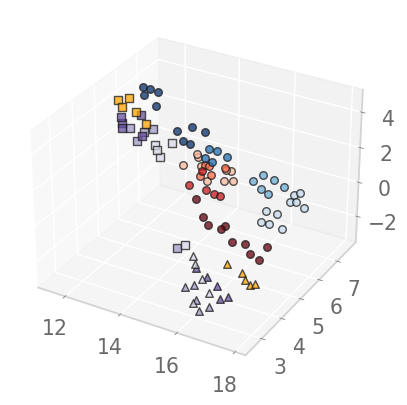

In [11]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')  # 3d
colors = ['orange', cm.get_cmap('Blues'), cm.get_cmap('Reds'), cm.get_cmap('Purples')]
color_steps = np.linspace(0.25, 1., env.HEIGHT, endpoint=True)
markers = ['s', '^', 'o']
for i in np.arange(reduced_latents.shape[0]):
    if xs[i] == env.CENTRAL_STEM:
        marker = markers[reward_locs[i]]
    else:
        marker = markers[-1]
    color_label = env._space_label[xs[i], ys[i]]
    if color_label == 0:
        color=colors[0]
    else:
        color_step = color_steps[ys[i]]
        color = colors[color_label](color_step)
    ax.scatter(
        reduced_latents[i,0], reduced_latents[i,1], reduced_latents[i,2],
        color=color,
        marker=marker, edgecolors='k', alpha=0.75, s=30
        )
plt.show()